In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.datasets import cifar10
import numpy as np
import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 26s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


In [3]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

In [4]:
def create_cnn_model(input_shape=(32, 32, 3)):
    inputs = Input(input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [5]:
random_state = 42
test_size = 0.1

x_train, x_val, _, _ = train_test_split(x_train, x_train, test_size=test_size, random_state=random_state)
masked_x_train, masked_x_val, _, _ = train_test_split(masked_x_train, masked_x_train, test_size=test_size, random_state=random_state)

print("Sets shapes: ",x_train.shape,x_val.shape,x_test.shape)
print("Masked sets shapes: ",masked_x_train.shape,masked_x_val.shape,masked_x_test.shape)

Sets shapes:  (45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)
Masked sets shapes:  (45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [6]:
image_shape = x_train[0].shape

model = create_cnn_model(image_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                             

In [7]:
batch_size=256
epochs = 30

history = model.fit(masked_x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(masked_x_val, x_val))

Epoch 1/30
176/176 [==============================] - 19s 63ms/step - loss: 0.0242 - val_loss: 0.0160
Epoch 2/30
176/176 [==============================] - 10s 56ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 3/30
176/176 [==============================] - 10s 57ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 4/30
176/176 [==============================] - 10s 56ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 5/30
176/176 [==============================] - 10s 56ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 6/30
176/176 [==============================] - 10s 58ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 7/30
176/176 [==============================] - 10s 57ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 8/30
176/176 [==============================] - 10s 57ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 9/30
176/176 [==============================] - 10s 58ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 10/30
176/176 [==============================] - 10s 57ms/step - loss: 0.010

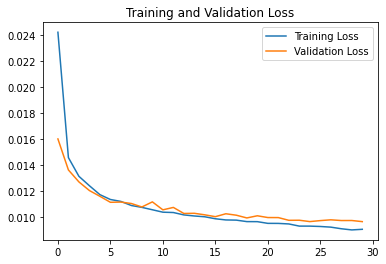

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [9]:
test_loss = model.evaluate(masked_x_test, x_test)
print('Test loss:', test_loss)

313/313 [==============================] - 3s 9ms/step - loss: 0.0096
Test loss: 0.009630795568227768


1/1 [==============================] - 0s 15ms/step


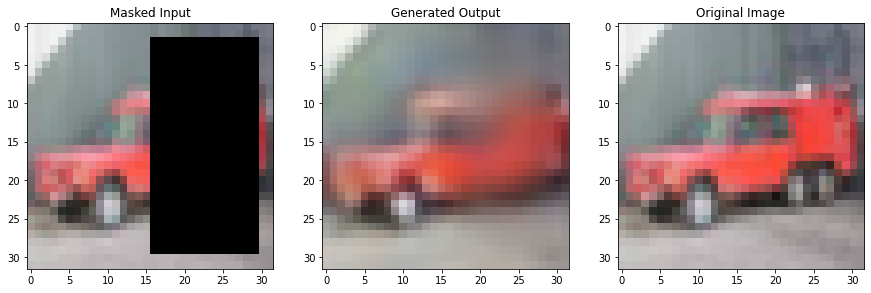

In [75]:
import matplotlib.pyplot as plt

# Choose an image from the test set
idx = np.random.randint(0, len(masked_x_test))
masked_img = masked_x_test[idx]
orig_img = x_test[idx]

# Predict the generated image using the model
gen_img = model.predict(np.expand_dims(masked_img, axis=0))[0]

# Plot the masked input and generated output
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(masked_img)
ax[0].set_title('Masked Input')
ax[1].imshow(gen_img)
ax[1].set_title('Generated Output')
ax[2].imshow(orig_img)
ax[2].set_title('Original Image')
plt.show()
